In [84]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
# 0 = all messages are logged (default behavior)
# 1 = INFO messages are not printed
# 2 = INFO and WARNING messages are not printed
# 3 = INFO, WARNING, and ERROR messages are not printed


In [85]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import SGD

from scipy.ndimage import convolve
from keras.models import Model
from keras.layers import Input, Dense, Layer, Conv2D, MaxPool2D, Flatten
from keras.losses import Loss

# **Convolutional Neural Networks (CNNs) - Theory**

A Convolutional Neural Network (CNN) is essentially a feedforward Multi-Layer Perceptron (MLP) that is designed to recognize local patterns and sparsity in input data. Like the MLP, each neuron is connected to others through learnable weights. These weights are adjusted during training to optimize the network's performance for a specific task.

The main difference between MLPs and CNNs is that the latter is developed for processing multidimensional data, such as images or videos. Also, CNNs have a more diverse set of specialized layers, including convolutional layers, pooling layers, and upsampling layers, which are optimized for processing spatial (image) and temporal data (video).

## **Convolutions**

Convolution is a mathematical operation that involves sliding a small matrix, known as a kernel or filter, across a larger matrix representing the input data, such as an image. During this process, the element-wise product $\odot$ is computed between the kernel and each local region (sub-matrix) it covers on the input data matrix. The result of this operation is a new matrix, called a feature map, which encodes information about the presence, absence, or strength of specific features in the input data.

Let's examine the following convolutional operations to illustrate this concept.


### **One Dimension**

Let's consider $\mathbf{x}$ as an input vector with $n$ elements and $\mathbf{w}$ as a weight vector, also known as a  **filter**, with $k \leq n$.

$$
\mathbf{x} =
\left( \begin{array}{c}
x_{1}\\
x_{2}\\
\vdots\\
x_{n}
\end{array} \right), ~~~~
\mathbf{w} =
\left( \begin{array}{c}
w_{1}\\
w_{2}\\
\vdots\\
w_{k}
\end{array} \right)
$$

Here $k$  is known as the  **window size** and indicates the size of the filter applied to the input vector $\mathbf{x}$. It defines the region of the local neighborhood within the input vector $\mathbf{x}$ used for computing output values. To proceed, we define a subvector of $\mathbf{x}$ with the same size as the filter vector. Let $\mathbf{x}_k(i)$ denote the window of $\mathbf{x}$  of size $k$ starting at position $i$:

$$\mathbf{x}_k(i) = \left( \begin{array}{c}
x_i \\
x_{i+1} \\
\vdots\\
x_{i+k-1} 
\end{array} \right).$$

For $k \leq n$, it must be that $i+k-1 \leq n$, implying $1 \leq i \leq n-k+1$. As a validity test, if we start at $i =  n-k+1$, then the end position is $i+k-1 = n$. If we calculate the total number of elements by the difference in position provides the window size $k$, confirmed by $n - i = n - (n-k+1) = k$. For example, with $n = 5$ and $k = 3$:

$$
\mathbf{x} =
\left( \begin{array}{c}
x_{1}\\
x_{2}\\
x_{3}\\
x_{4}\\
x_{5}
\end{array} \right), ~~~~
\mathbf{w} =
\left( \begin{array}{c}
w_{1}\\
w_{2}\\
w_{3}
\end{array} \right)
$$

the window of $\mathbf{x}$ from $i = 2$ to $i+k-1 = 4$ is:

$$\mathbf{x}_3(2) = \left( \begin{array}{c}
x_2 \\
x_{3}\\
x_{4}
\end{array} \right)$$

**Example**

Let's first consider a particular example with input vector $\mathbf{x}$ of size $n = 5$ and a weight vector with window size $k = 3$. The vectors are illustrated in the following figure:

<center><img src = "figures/1d-conv.png" width="800" height="400"/></center>


The convolution steps for the sliding windows of $\mathbf{x}$ with the filter $\mathbf{w}$ are:


$$
\sum \mathbf{x}_3(1) \odot \mathbf{w} = \sum (1, 3, -1)^T \odot (1, 0, 2)^T = \sum  (1 \cdot 1, 3 \cdot 0, -1 \cdot 2) = 1 + 0 - 2 = -1,
$$

$$
\sum \mathbf{x}_3(2) \odot \mathbf{w} = \sum (3, -1, 2)^T \odot (1, 0, 2)^T = \sum  (3 \cdot 1, -1 \cdot 0, 2 \cdot 2) = 3 + 0 + 4 = 7,
$$

$$
\sum \mathbf{x}_3(3) \odot \mathbf{w} = \sum (-1, 2, 3)^T \odot (1, 0, 2)^T = \sum  (-1 \cdot 1, 2 \cdot 0, 3 \cdot 2) = -1 + 0 + 6 = 5.
$$

The element-wise product $\odot$  , also known as the Hadamard product, multiplies corresponding elements in two vectors. Unlike the typical inner product, which multiplies an element by a column, this operation multiplies an element by its corresponding element in another vector. This steps provide the convolution between the two vectors resulting in a vector of size n-k+1 = 3. Thus, the convolution $\mathbf{x} * \mathbf{w}$ is:

$$\mathbf{x} * \mathbf{w} =
\left( \begin{array}{c}
-1\\
7\\
5
\end{array} \right)$$

In [86]:
# Code for the example

X = np.array([1, 3, -1, 2, 3])
# flip the filter W to use the convolve function
# as expected in machine learning and deep learning context
W = np.flip(np.array([1, 0, 2]))

# perform 1D convolution
output = np.convolve(X, W, mode='valid')

print("Input vector X:", X.shape)
print("filter W:", W.shape)
print("output X*W:", output)

Input vector X: (5,)
filter W: (3,)
output X*W: [-1  7  5]


This demonstrates that convolution is an element-wise product between a subvector and a weight vector of the same size, providing a scalar value when summed, which forms the result of the convolution operation.

To simplify the notation, let's adopt the convention that for a vector $\mathbf{a} \in \mathbb{R}^k$, define the summation operator as one that adds all elements of the vector. That is, 

$$\text{Sum}(\mathbf{a}) = \sum_{i=1}^{k} a_{i}$$ 

Then from the example, we would have

$$
\sum \mathbf{x}_3(1) \odot \mathbf{w} = \text{Sum}\bigg( \mathbf{x}_3(1) \odot \mathbf{w} \bigg)= 1 + 0 - 2 = -1.
$$

Then, we can define a general one dimensional convolution operation between $\mathbf{x}$ and $\mathbf{w}$, denoted by the asterisk symbol $\ast$, as 

$$\mathbf{x} \ast \mathbf{w} = \left( \begin{array}{c}
\text{Sum}(\mathbf{x}_k(1) \odot \mathbf{w})\\
\vdots\\
\text{Sum}(\mathbf{x}_k(i) \odot \mathbf{w})\\
\vdots\\
\text{Sum}(\mathbf{x}_k(n-k+1) \odot \mathbf{w})
\end{array} \right).$$

The convolution of $\mathbf{x} \in \mathbf{R}^{n}$ and $\mathbf{W} \in \mathbf{R}^{k}$ results in a vector of size $n-k+1$. The i-th element from this output vector can be decomposed as

$$\text{Sum}(\mathbf{x_k}(i) \odot \mathbf{w}) = x_{i}w_1 + x_{i+1}w_2 + \cdots + x_{(i+k-1)}w_k =  \sum_{j=1}^{k} x_{(i+j-1)}w_j.$$

This shows that the sum is over all elements of the subvector $\mathbf{x}_k(i)$, so the last element of this sum must coincide with the last elements of $\mathbf{x}_k(i)$ and $\mathbf{w}$. This results in the convolution of $\mathbf{x}$ with $\mathbf{w}$ over the window defined by $k$.

### **Two Dimension**

We can extend the convolution operation to an matrix input instead of a vector. Let $\mathbf{X}$ be an input matrix with $n \times n$ elements and $\mathbf{W}$ be the weight matrix, also known as a  **filter**, with $k \leq n$.

$$
\mathbf{X} = \begin{bmatrix}
x_{1,1} & x_{1,2} & \cdots & x_{1,n} \\
x_{2,1} & x_{2,2} & \cdots & x_{2,n} \\
\vdots & \vdots & \ddots & \vdots \\
x_{n,1} & x_{n,2} & \cdots & x_{n,n}
\end{bmatrix},~~
\mathbf{W}=\begin{bmatrix}
w_{1,1} & w_{1,2} & \cdots & w_{1,k} \\
w_{2,1} & w_{2,2} & \cdots & w_{2,k} \\
\vdots & \vdots & \ddots & \vdots \\
w_{k,1} & w_{k,2} & \cdots & w_{k,k}
\end{bmatrix}
$$

Here, similar to the one dimensional case,  $k$ is the window size and indicates the size of the filter applied to the input matrix $\mathbf{X}$. From the one dimensional case we can extend the notion of a sub vector to a sub matrix. Let $\mathbf{X}_k(i,j)$ denote the $k \times k$ submatrix of $\mathbf{X}$ starting at row $i$ and column $j$ as

$$\mathbf{X}_k(i,j) = \begin{bmatrix}
x_{i,j} & x_{i,~(j+1)} & \cdots & x_{i,~(j+k-1)} \\
x_{(i+1),~j} & x_{(i+2),~j} & \cdots & x_{(i+1), (j+k-1)} \\
\vdots & \vdots & \ddots & \vdots \\
x_{(i+k-1), ~j} & x_{(i+1),(j+1)} & \cdots & x_{(i+k-1),(j+k-1)}
\end{bmatrix}$$

where for two indices, give that this is a square matrix, the range is simple $1 \leq (i,j) \leq n-k+1$.

As for the one dimensional case, to simplify the notation, we adopt the convention that for a matrix $\mathbf{A} \in \mathbb{R}^{k \times k}$ define the summation operator as one that adds all elements of the matrix.

$$\text{Sum}(\mathbf{A}) = \sum_{i=1}^{k}\sum_{j=1}^{k} a_{i,j}$$

Then, we can define  a general two dimensional convolution operation between matrices $\mathbf{X}$ and $\mathbf{W}$, as


$$\mathbf{X} \ast \mathbf{W} = \begin{bmatrix}
\text{Sum}(x_k(1,1) \odot \mathbf{W}) &\text{Sum}(x_k(1,2) \odot \mathbf{W}) & \cdots & \text{Sum}(x_k(1,n-k+1) \odot \mathbf{W}) \\
\text{Sum}(x_k(2,1) \odot \mathbf{W}) & \text{Sum}(x_k(2,2) \odot \mathbf{W}) & \cdots &\text{Sum}(x_k(2,n-k+1) \odot \mathbf{W})\\
\vdots & \vdots & \ddots & \vdots \\
\text{Sum}(x_k(n-k+1,1) \odot \mathbf{W}) & \text{Sum}(x_k(n-k+1,2) \odot \mathbf{W}) & \cdots & \text{Sum}(x_k(n-k+1,n-k+1) \odot \mathbf{W})
\end{bmatrix}$$

where

$$\text{Sum}(\mathbf{X}_k(i,j) \odot \mathbf{W})=\sum_{a=1}^{k}\sum_{b=1}^{k} x_{(i+a-1),(j+b-1)} w_{a,b}$$

The convolution of $\mathbf{X} \in \mathbf{R}^{n \times n}$ and $\mathbf{W} \in \mathbf{R}^{k \times k}$ results in a $(n-k+1) \times (n-k+1)$ matrix.

**Example**

Let's consider a particular example with input matrix $\mathbf{X}$ with dimension  $3 \times 3$ (n = 3) and a weight matrix with dimension  $2 \times 2$ (k = 2). The matrices are illustrated in the following figure:

<center><img src = "figures/2d-conv.png" width="800" height="400"/></center>

The convolution steps for the sliding windows of $\mathbf{X}$ with the filter $\mathbf{W}$ illustrated in the figure are mathematically translated to:


$$\text{Sum}(\mathbf{X}_k(1,1) \odot \mathbf{W})=\text{Sum}\bigg(
    \begin{bmatrix} 
    1 & 2 \\
    3 & 1 
    \end{bmatrix} 
    \odot 
    \begin{bmatrix} 
    1 & 0 \\
    0 & 1
    \end{bmatrix} \bigg) =  2$$

$$\text{Sum}(\mathbf{X}_2(1,2) \odot \mathbf{W}) = \text{Sum}\bigg(
    \begin{bmatrix} 
    2 & 2 \\
    1 & 4
    \end{bmatrix} 
    \odot
    \begin{bmatrix}
    1 & 0 \\
    0 & 1
    \end{bmatrix} \bigg)= 6$$


$$\text{Sum}(\mathbf{X}_2(2,1) \odot \mathbf{W}) = \text{Sum}\bigg( 
    \begin{bmatrix} 
    3 & 1 \\ 
    2 & 1 \end{bmatrix} 
    \odot \begin{bmatrix} 
    1 & 0 \\ 
    0 & 1 
    \end{bmatrix} \bigg)= 4$$


$$\text{Sum}(\mathbf{X}_2(2,2) \odot \mathbf{W}) = \text{Sum}\bigg( 
    \begin{bmatrix} 
    1 & 4 \\
    3 & 3 \end{bmatrix}
    \odot
    \begin{bmatrix}
    1 & 0 \\ 
    0 & 1
    \end{bmatrix} \bigg) = 4$$

The convolution $\mathbf{X}*\mathbf{W}$ has size $2 \times 2$, since  $n - k + 1 = 3 - 2 + 1 = 2$, and is given by

$$\mathbf{X}*\mathbf{W} = 
    \begin{bmatrix} 
        \text{Sum}(\mathbf{X}_2(1,1) \odot \mathbf{W}) & \text{Sum}(\mathbf{X}_2(1,2) \odot \mathbf{W}) \\
        \\
        \text{Sum}(\mathbf{X}_2(2,1) \odot \mathbf{W}) & \text{Sum}(\mathbf{X}_2(2,2) \odot \mathbf{W}) 
    \end{bmatrix} = 
    \begin{bmatrix} 
        2 & 6 \\
        4 & 4 
    \end{bmatrix}$$

## **Three dimensional Convolution on CNNs**



We now extend the convolution operation to a three-dimensional matrix, also called a rank-3 tensor. The first dimension comprises the rows (height), second dimension the columns (width) and the third dimension the channels (number of 2D slices stacked along the depth axis). Typically in CNNs, we use a 3D filter $\mathbf{W} \in \mathbb{R}^{k \times k \times m}$, with the number of channels equal to the number of channels of the input tensor $\mathbf{X} \in \mathbb{R}^{n \times n \times m}$, in this case with $m$ channels each. Mathematically we represent as:

$$
\mathbf{X}=
\begin{bmatrix}
\begin{bmatrix}
x_{1,1,1} & x_{1,2,1} & \cdots & x_{1,n,1} \\
x_{2,1,1} & x_{2,2,1} & \cdots & x_{2,n,1} \\
\vdots & \vdots & \ddots & \vdots \\
x_{n,1,1} & x_{n,2,1} & \cdots & x_{n,n,1}
\end{bmatrix}\\
\\
\begin{bmatrix}
x_{1,1,2} & x_{1,2,2} & \cdots & x_{1,n,2} \\
x_{2,1,2} & x_{2,2,2} & \cdots & x_{2,n,2} \\
\vdots & \vdots & \ddots & \vdots \\
x_{n,1,2} & x_{n,2,2} & \cdots & x_{n,n,2}
\end{bmatrix}\\
\\
\vdots\\
\\
\begin{bmatrix}
x_{1,1,m} & x_{1,2,m} & \cdots & x_{1,n,m} \\
x_{2,1,m} & x_{2,2,m} & \cdots & x_{2,n,m} \\
\vdots & \vdots & \ddots & \vdots \\
x_{n,1,m} & x_{n,2,m} & \cdots & x_{n,n,m}
\end{bmatrix}
\end{bmatrix},~~


\mathbf{W}= \begin{bmatrix}
\begin{bmatrix}
w_{1,1,1} & w_{1,2,1} & \cdots & w_{1,k,1} \\
w_{2,1,1} & w_{2,2,1} & \cdots & w_{2,k,1} \\
\vdots & \vdots & \ddots & \vdots \\
w_{k,1,1} & w_{k,2,1} & \cdots & w_{k,k,1}
\end{bmatrix}\\
\\
\begin{bmatrix}
w_{1,1,2} & w_{1,2,2} & \cdots & w_{1,k,2} \\
w_{2,1,2} & w_{2,2,2} & \cdots & w_{2,k,2} \\
\vdots & \vdots & \ddots & \vdots \\
w_{k,1,2} & w_{k,2,2} & \cdots & w_{k,k,2}
\end{bmatrix}
\\
\vdots\\
\\
\begin{bmatrix}
w_{1,1,r} & w_{1,2,r} & \cdots & w_{1,k,m} \\
w_{2,1,r} & w_{2,2,r} & \cdots & w_{2,k,m} \\
\vdots & \vdots & \ddots & \vdots \\
w_{k,1,r} & w_{k,2,r} & \cdots & w_{k,k,m}

\end{bmatrix}
\end{bmatrix}
$$

Similar to convolutions in other dimensions, the window size must satisfy $k \leq n$, and the total number of slice matrices along the depth of the filter and input tensor are fixed as $m$. This mathematical representation of a tensor may seem complex at first, but it closely resembles how Python libraries like NumPy represent a tensor, with exception of the order of rows, columns and depth.

When defining a sub-tensor from the input tensor $\mathbf{X}$, let $\mathbf{X}_k(i,j)$ denote a $k \times k \times m$ sub-tensor of $\mathbf{X}$ that starts at row $i$, column $j$, and encompasses the full depth $m$ of the input. In the context where the filter spans the entire depth of the input (i.e., the number of channels $r$ in the filter is equal to the depth $m$ of the input), the depth index $q$ is not needed because the filter processes all depth layers simultaneously. Therefore, the sub-tensor $\mathbf{X}_k(i,j)$ is defined as follows:


$$
\mathbf{X}_k(i,j,q = m)= \mathbf{X}_k(i,j) =
\begin{bmatrix}
\begin{bmatrix}
x_{i,j,1} & x_{i,(j+1),1} & \cdots & x_{i,(j+k-1),1} \\
x_{(i+1),j,1} & x_{(i+1),(j+1),1} & \cdots & x_{(i+1),(j+k-1),1} \\
\vdots & \vdots & \ddots & \vdots \\
x_{(i+k-1),j,1} & x_{(i+k-1),(j+1),1} & \cdots & x_{(i+k-1),(j+k-1),1}
\end{bmatrix}\\
\\
\\
\begin{bmatrix}
x_{i,j,2} & x_{i,(j+1),2} & \cdots & x_{i,(j+k-1),2} \\
x_{(i+1),j,2} & x_{(i+1),(j+1),2} & \cdots & x_{(i+1),(j+k-1),2} \\
\vdots & \vdots & \ddots & \vdots \\
x_{(i+k-1),j,2} & x_{(i+k-1),(j+1),2} & \cdots & x_{(i+k-1),(j+k-1),2}
\end{bmatrix}\\
\\
\vdots\\
\\
\begin{bmatrix}
x_{i,j,m} & x_{i,(j+1),m} & \cdots & x_{i,(j+k-1),m} \\
x_{(i+1),j,m} & x_{(i+1),(j+1),m} & \cdots & x_{2,n,m} \\
\vdots & \vdots & \ddots & \vdots \\
x_{(i+k-1),j,m} & x_{(i+k-1),(j+1),m} & \cdots & x_{(i+k-1),(j+k-1),m}
\end{bmatrix}
\end{bmatrix}
$$

The indices from the subtensor for rows and columns range from $1 \leq (i,j) \leq n-k+1$, where $n$ is the dimension of the input $\mathbf{X}$ and $k$ is the window size of the filter $\mathbf{W}$, consistent with two-dimensional convolutions. The depth dimension is fixed at $m$, so it's redundant carrying $q = m$ in our notation. 

As in the case of convolution in lower dimensions, we define the summation operator as one that adds all elements within the tensor. Therefore, given a tensor $\mathbf{A} \in \mathbb{R}^{k \times k \times m}$, the summation operation is defined as:

$$\text{Sum}(\mathbf{A}) = \sum_{a=1}^{k}\sum_{b=1}^{k}\sum_{q=1}^{m}a_{ijq}$$

This summation adds up all the elements in the tensor $\mathbf{A}$, where $a_{ijq}$ denotes the element located at the $i$-th row, $j$-th column, and $q$-th depth layer.


Before we generalize the convolution operation to three dimensions, let's consider an example to illustrate the logic behind this mathematical notation and how it translates to the operations performed in a CNN.

**Example**

Consider a input tensor $\mathbf{X}$ with dimension  $3 \times 3 \times 3$ (n = 3 and m = 3 channels) and a filter with dimension  $2 \times 2 \times 3$ ( windows size with k = 2 and m = 3 channels). The tensors are illustrated in the following figure:

<center><img src = "figures/3d-conv.png" ></center>


The convolution steps for the sliding windows of $\mathbf{X}$ with the filter $\mathbf{W}$ illustrated in the figure are:

$$
\text{Sum}(\mathbf{X}_2(1,1) \odot \mathbf{W}) = \text{Sum}\bigg( 
\begin{bmatrix} 
    \begin{bmatrix} 
        1 & -1 \\ 
        2 & 1 
    \end{bmatrix} \\
    \\
    \begin{bmatrix} 
        2 & 1 \\
        3 & -1
    \end{bmatrix} \\
    \\
    \begin{bmatrix} 
        1 & -2 \\ 
        2 & 1 
    \end{bmatrix} 
\end{bmatrix} 
\odot 
\begin{bmatrix} 
    \begin{bmatrix} 
        1 & 1 \\
        2 & 0 
    \end{bmatrix} \\
    \\
    \begin{bmatrix} 
        1 & 0 \\ 
        0 & 1
    \end{bmatrix} \\
    \\
    \begin{bmatrix}
        0 & 1 \\
        1 & 0 
    \end{bmatrix} 
\end{bmatrix} \bigg) = \text{Sum}\bigg(   
    \begin{bmatrix} 
    \begin{bmatrix} 
        1  & -1  \\ 
        4 & 0 
    \end{bmatrix} \\
    \\
    \begin{bmatrix} 
        2 & 0 \\
        0 & -1
    \end{bmatrix} \\
    \\
    \begin{bmatrix} 
        0 & -2 \\ 
        2 & 0 
    \end{bmatrix} 
\end{bmatrix} \bigg) = 1 - 1 + 4 +2 -1 -2+ 2 = 5 
$$


$$
\text{Sum}(\mathbf{X}_2(1,2) \odot \mathbf{W}) = \text{Sum}\bigg(
\begin{bmatrix}
    \begin{bmatrix}
        -1 & 3 \\
        1 & -4
    \end{bmatrix} \\
    \\
    \begin{bmatrix}
        1 & 3 \\
        -1 & 1
    \end{bmatrix} \\
    \\
    \begin{bmatrix}
        -2 & 4 \\
        1 & -2
    \end{bmatrix}
\end{bmatrix}
\odot
\begin{bmatrix}
    \begin{bmatrix}
        1 & 1 \\
        2 & 0
    \end{bmatrix} \\
    \\
    \begin{bmatrix}
        1 & 0 \\
        0 & 1
    \end{bmatrix} \\
    \\
    \begin{bmatrix}
        0 & 1 \\
        1 & 0
    \end{bmatrix}
\end{bmatrix} \bigg) = \text{Sum}\bigg(
\begin{bmatrix}
\begin{bmatrix}
    -1 & 3 \\
    2 & 0
\end{bmatrix} \\
\\
\begin{bmatrix}
    1 & 0 \\
    0 & 1
\end{bmatrix} \\
\\
\begin{bmatrix}
    0 & 4 \\
    1 & 0
\end{bmatrix}
\end{bmatrix} \bigg) = -1 + 3 + 2 + 1 + 1 + 4 + 1 = 11 
$$


$$
\text{Sum}(\mathbf{X}_2(2,1) \odot \mathbf{W}) = \text{Sum}\bigg(
\begin{bmatrix}
\begin{bmatrix}
    2 & 1 \\
    3 & 1
\end{bmatrix} \\
\\
\begin{bmatrix}
    3 & -1 \\
    1 & 1
\end{bmatrix} \\
\\
\begin{bmatrix}
    2 & 1 \\
    1 & 3
\end{bmatrix}
\end{bmatrix}
\odot
\begin{bmatrix}
\begin{bmatrix}
    1 & 1 \\
    2 & 0
\end{bmatrix} \\
\\
\begin{bmatrix}
    1 & 0 \\
    0 & 1
\end{bmatrix} \\
\\
\begin{bmatrix}
    0 & 1 \\
    1 & 0
\end{bmatrix}
\end{bmatrix} \bigg) = \text{Sum}\bigg(
\begin{bmatrix}
\begin{bmatrix}
    2 & 1 \\
    6 & 0
\end{bmatrix} \\
\\
\begin{bmatrix}
    3 & 0 \\
    0 & 1
\end{bmatrix} \\
\\
\begin{bmatrix}
    0 & 1 \\
    1 & 0
\end{bmatrix}
\end{bmatrix} \bigg) = 2 + 1 + 6 + 3 + 1 + 1 + 1 = 15
$$


$$
\text{Sum}(\mathbf{X}_2(2,2) \odot \mathbf{W}) = \text{Sum}\bigg(
\begin{bmatrix}
\begin{bmatrix}
    1 & 4 \\
    1 & 2
\end{bmatrix} \\
\\
\begin{bmatrix}
    -1 & 1 \\
    1 & -2
\end{bmatrix} \\
\\
\begin{bmatrix}
    1 & -2 \\
    3 & -1
    \end{bmatrix}
\end{bmatrix}
\odot
\begin{bmatrix}
\begin{bmatrix}
    1 & 1 \\
    2 & 0
\end{bmatrix} \\
\\
\begin{bmatrix}
    1 & 0 \\
    0 & 1
\end{bmatrix} \\
\\
\begin{bmatrix}
    0 & 1 \\
    1 & 0
\end{bmatrix}
\end{bmatrix} \bigg) = \text{Sum}\bigg(
\begin{bmatrix}
\begin{bmatrix}
    1 & 4 \\
    2 & 0
\end{bmatrix} \\
\\
\begin{bmatrix}
    -1 & 0 \\
    0 & -2
\end{bmatrix} \\
\\
\begin{bmatrix}
    0 & -2 \\
    3 & 0
\end{bmatrix}
\end{bmatrix} \bigg) = 1 + 4 +  2 + -1 - 2 - 2 + 3  = 5 
$$

The convolution $\mathbf{X}*\mathbf{W}$ has size $2 \times 2$, since  $n - k + 1 = 3 - 2 + 1 = 2$, and $m = 3$; it is is given as

 $$\mathbf{X}*\mathbf{W} = 
 \begin{bmatrix}
    \text{Sum}(\mathbf{X}_2(1,1) \odot \mathbf{W}) & \text{Sum}(\mathbf{X}_2(1,2) \odot \mathbf{W}) \\
    \\
    \text{Sum}(\mathbf{X}_2(2,1) \odot \mathbf{W}) & \text{Sum}(\mathbf{X}_2(2,2) \odot \mathbf{W})
\end{bmatrix}
=
\begin{bmatrix}
    5 & 11 \\
    15 & 5
\end{bmatrix}
$$

In [87]:
X = np.array([
    [[1, -1, 3],
     [2, 1, 4],
     [3, 1, 2]],

    [[2, 1, 3],
     [3, -1, 1],
     [1, 1, -2]],

    [[1, -2, 4],
     [2, 1, -2],
     [1, 3, -1]]
], dtype=np.float32)

# TensorFlow expects the input to have a shape of [batch, (depth, height, width), channels]
# Add a batch dimension and a channel dimension to X
X = X.reshape(1, *X.shape, 1) 
# create a simple 3D kernel
W = np.array([
    [[1, 1],
     [2, 0]],

    [[1, 0],
     [0, 1]],

    [[0, 1],
     [1, 0]]
], dtype=np.float32)

# TensorFlow expects the filter to have a shape of [(depth, height, width), in_channels = 1, out_channels = 1]
# Since our input has a single channel (in_channels = 1) and we want a single output channel ( out_channels = 1),
# Add those dimensions to W
W = W.reshape(*W.shape, 1, 1) 

# 3D convolution
output = tf.nn.conv3d(input=X, filters=W, strides=[1, 1, 1, 1, 1], padding="VALID")

# squeeze to remove the redundant dimensions of batch and channel
output_2d = output.numpy().squeeze()    

print("Shape of input tensor X:\n", X.shape)
print("Shape of filter tensor W:\n", W.shape)
print("Convolved output shape with channel and batch dimension:\n", output.shape)
print("Convolved output:\n", output_2d)

Shape of input tensor X:
 (1, 3, 3, 3, 1)
Shape of filter tensor W:
 (3, 2, 2, 1, 1)
Convolved output shape with channel and batch dimension:
 (1, 1, 2, 2, 1)
Convolved output:
 [[ 5. 11.]
 [15.  5.]]


When the number of channels is fixed for both tensors the result of the convolution is a matrix of two dimension, and not a tensor. The matrix from the convolution has dimension $(n-k+1) \times (n-k+1)$ and can be represented as:

$$
\mathbf{X} \ast \mathbf{W} = 
\begin{bmatrix}
\text{Sum}(X_k(1,1) \odot \mathbf{W})  & \cdots & \text{Sum}(X_k(1,n-k+1) \odot \mathbf{W}) \\
\vdots  & \ddots & \vdots \\
\text{Sum}(X_k(n-k+1,1) \odot \mathbf{W}) & \cdots & \text{Sum}(X_k(n-k+1,n-k+1) \odot \mathbf{W})
\end{bmatrix}
$$

where 

$$
\begin{align*}
\text{Sum}(\mathbf{X}_k(i,j) \odot \mathbf{W}) = \sum_{a=1}^{k}\sum_{b=1}^{k}\sum_{c=1}^{m}x_{(i+a-1),(j+b-1),~c}~w_{a,b,c}
\end{align*}
$$

for $(i,j) = 1,2, \cdots, n-k+1$.


This process can be visualized as each slice of the filter $\mathbf{W}$ matching with a corresponding slice in $\mathbf{X}$, aggregating information across all channels to form a 2D matrix that represents the features extracted from the input tensor $\mathbf{X}$.

In conclusion, the channels of the input tensor $\mathbf{X}$ represent various features of the input data, and the filter $\mathbf{W}$ is used to extract these features by convolving it with $\mathbf{X}$. By using a filter with the same number of channels as the input, each channel's features are processed, allowing the network to learn from each aspect of the input data separately.


## **Convolutional Layer**

In a CNN, the input tensor is generally denoted as $\mathbf{X} \in \mathbb{R}^{n_0 \times n_0 \times m_0}$, where  $n_0 \times n_0$ represents the spatial dimensions of a 2D input image (e.g., pixels), and $ m_0$ represents the depth, such as 1 for grayscale images or 3 for RGB color images. This input tensor is convolved with multiple filters designed to extract relevant information or features. After convolution, these feature are passed through activation functions within the convolutional layer  $\mathbf{Z}^1$, which introduce non-linear properties to the model. The process then repeat itself for the subsequent convolutional layers. 

To exemplify this process, consider two filters $\mathbf{W}_1$ and $\mathbf{W}_2$, which convolve with the input tensor $\mathbf{X}$ to pass the extracted features to the the convolutional layer  $\mathbf{Z}^1 \in \mathbb{R}^{n_1 \times n_1 \times m_1}$:


<center><img src = "figures/conv-input-hidden.png" /></center>

Considering a input tensor $\mathbf{X}$ with spatial dimension $n_0 = 3$ and $m_0 = 3$ channels convolved with two filters $\mathbf{W}_1$ and $\mathbf{W}_2$ with window size  $k = 2$, we obtain the output tensor at layer $\mathbf{Z}^1$. the dimension of $\mathbf{Z}^1$ is 
$(n_0 - k + 1) \times (n_0 - k + 1) \times m_1$, resulting in a $2 \times 2 \times 2$ tensor, where $m_1 = 2$ corresponding to the number of filters applied.

Let's incorporate the bias terms $b_1, b_2 \in \mathbb{R}$ corresponding to each filter $\mathbf{W}_1$ and $\mathbf{W}_2$, and a activation function $f(~ . ~)$. We represent a single  forward step in our simplified visualization of a CNN, going from input to the subsequent layer as:

$$
{\mathbf{net}^1}  = 
\begin{bmatrix}
    \begin{bmatrix}
        \text{Sum}(X_2(1,1) \odot \mathbf{W}_1)+b_1& \text{Sum}(X_2(1,2) \odot \mathbf{W}_1) +b_1
        \\
        \\
        \text{Sum}(X_2(2,1) \odot \mathbf{W}_1)+b_1& \text{Sum}(X_2(2,2) \odot \mathbf{W}_1)+b_1
    \end{bmatrix}\\
    \\
    \\
    \begin{bmatrix}
    \text{Sum}(X_2(1,1)  \odot \mathbf{W}_2)+b_2& \text{Sum}(X_2(1,2) \odot \mathbf{W}_2) +b_2
    \\
    \\
    \text{Sum}(X_2(2,1) \odot \mathbf{W}_2)+b_2& \text{Sum}(X_2(2,2) \odot \mathbf{W}_2)+b_2
    \end{bmatrix}
\end{bmatrix}
$$

The net signal after convolution is followed by the activation function to introduce non-linearity:

$$
{\mathbf{Z}^1} = f(\mathbf{net}^1) = 
\begin{bmatrix}
\\
    \begin{bmatrix}
        f(\text{Sum}(X_2(1,1) \odot \mathbf{W}_1) +b_1)& f(\text{Sum}(X_2(1,2) \odot \mathbf{W}_1)+b_1) 
        \\
        \\
        f(\text{Sum}(X_2(2,1) \odot \mathbf{W}_1)+b_1)& f(\text{Sum}(X_2(2,2) \odot \mathbf{W}_1)+b_1)
    \end{bmatrix}\\
    \\
    \\
    \begin{bmatrix}
    f(\text{Sum}(X_2(1,1) \odot \mathbf{W}_2) + b_2)& f(\text{Sum}(X_2(1,2) \odot \mathbf{W}_2) + b_2)
    \\
    \\
    f(\text{Sum}(X_2(2,1) \odot \mathbf{W}_2)+ b_2)& f(\text{Sum}(X_2(2,2) \odot \mathbf{W}_2)+ b_2)
    \end{bmatrix}
\end{bmatrix}.
$$

Resulting in the feature map, which represents the actual output of the layer after applying the activation function to the net signal. The activation function can be one commonly used in neural networks, such as identity, sigmoid, tanh, or ReLU. In the language of convolutions, this is simplified as:

$$
{\mathbf{Z}^1} = 
\begin{bmatrix}
    f(\mathbf{X} * \mathbf{W}_1 \oplus b_1)\\
    \\
    f(\mathbf{X} * \mathbf{W}_2 \oplus b_2)
\end{bmatrix},
$$

where $\oplus$ denotes the addition of the bias term to each element of the feature maps produced by $\mathbf{X} * \mathbf{W}_1$ and $\mathbf{X} * \mathbf{W}_2$. For a compact representation:

$$
{\mathbf{Z}^1} = f(\mathbf{X} * \mathbf{W}_1 \oplus b_1,  \mathbf{X} * \mathbf{W}_2 \oplus b_2)
$$

Extending this concept to a more general and formal case, from the $l$-th layer to the $l+1$-th layer with multiple filters, we denote the tensor at layer $l$ as $\mathbf{Z}^l \in \mathbb{R}^{n_l \times n_l \times m_l}$. Each element $Z_{i,j,q}^l$ of the tensor represents the output value of a neuron located at row $i$, column $j$, and channel $q$ for layer $l$, where $1 \leq (i,j) \leq n_l$ and $1 \leq q \leq m_l$. Assuming we have $m_{l+1}$ filters $\{\mathbf{W}_1, \cdots, \mathbf{W}_{m_{l+1}}\}$, the output feature map passed through the next layer will have $m_{l+1}$ channels.

The convolution $f(\mathbf{Z}^l * \mathbf{W}_q \oplus b_q)$ for a given filter $q$ produces a feature map matrix of dimension $(n_l-k+1) \times (n_l-k+1)$, where each element of this feature map corresponds to a neuron's output at layer $l+1$. Convolving $\mathbf{Z}^l$ with all $m_{l+1}$ filters, we form the tensor $\mathbf{Z}^{l+1}$ for layer $l+1$ with dimensions $(n_l-k+1) \times (n_l-k+1) \times m_{l+1}$. The result for this tensor at layer $l+1$ is:

$$
{\mathbf{Z}^{l+1}} = f\bigg(\big(\mathbf{Z}^l * \mathbf{W}_1 \oplus b_1\big), \cdots,\big(\mathbf{Z}^l * \mathbf{W}_q \oplus b_q\big), \cdots, \big( \mathbf{Z}^l * \mathbf{W}_{m_{l+1}} \oplus b_{m_{l+1}}\big)\bigg)
$$

In summary, a Convolutional Layer takes as input the $n_l \times n_l \times m_l$ tensor  $\mathbf{Z}^l$ of neurons from layer $l$, and then computes the $n_{l+1} \times n_{l+1} \times m_{l+1}$ tensor $\mathbf{Z}^{l+1}$ of neurons for the next layer $l+1$ via the convolution of $\mathbf{Z}^{l}$ with $m_{l+1}$ different  filters of size $k \times k \times m_l$, followd by adding the bias and applying some non-linear activation function $f(~.~)$.

### **Padding and Striding**

One of the problem with the convolution operation is that the size of the tensor will decrease in each successive layer. If a tensor $\mathbf{Z}^l$ at layer $l$ has size $n_l \times n_l \times m_l$, and  we use filters of size $k \times k \times m_l$, then each channel in a layer $l+1$ will have size $(n_l - (k - 1)) \times (n_l-(k -1))$. That is, the number of rows and columns for each successive tensor will shrink by $k-1$.


**Padding**

Padding involves adding zeros or other values around the edges of the input data before applying a convolutional filter. The purpose of padding is to preserve the spatial dimensions of the input data in the output feature map. Without padding, the spatial dimensions of the output feature map would be reduced after each convolutional layer, leading to the loss of important spatial information. By adding padding, the spatial dimensions of the output feature map can be preserved or even increased.

Assume that we add $p$ rows and columns of zeros. With padding $p$, the new dimension of tensor $\mathbf{Z}^l$ at layer $l$ is $(n_l + 2p) \times (n_l +2p) \times m_l$. Assuming that each filter is of size $k \times k \times m_l$, and that there are $m_{l+1}$ filters, then the size of tensor $\mathbf{Z}^{l+1}$ at layer $l+1$ will be $(n_l + 2p -(k-1)) \times (n_l + 2p-(k-1)) \times m_{l+1}$. Since we want to preserve or increase the size of the resulting tensor, we need to have the following lower bound when choosing the padding:

$$n_l +2p - k + 1  \geq n_l$$

which implies $p \geq \frac{k-1}{2}$. So the result size after convolution with padding $p$ will be 

$$Dim(\mathbf{Z}^{l+1})= (n_l + 2p -(k-1)) \times (n_l + 2p-(k-1)) \times m_{l+1}.$$




**Striding**

Striding, on the other hand, involves controls the slide size steps of the filter channels across the sub tensor (or window) of  $\mathbf{Z}^l$ in the convolution operation. Until now we implicitly use a stride of size $s = 1$ as

$$
\begin{align*}
\text{Sum}(\mathbf{Z}^l_k(i,j) \odot \mathbf{W})
\end{align*}
$$

for $(i,j) = 1,2, \cdots, n_l-k+1$, where the indices $i$ and $j$ increase by $s = 1$ at each step. For a given stride $s$, the set of indices $(i,j)$ can be written as:

$$
\text{for stride } s, \quad (i,j) = 1 + 0\cdot s,1+1 \cdot s,1+2\cdot s, \cdots,1 + t\cdot s
$$

where $t$ is the largest integer such that $1 + ts \leq n_l - k + 1$. This ensures that the applied filter starting from the first element and slide it over the matrix by $s$ elements each time, stopping at the correct boundary without exceeding the size of the window matrix. this results in 

$$
t \leq \left\lfloor \frac{n_l - k}{s} \right\rfloor
$$

the symbol $\lfloor ~ \rfloor$ means rounding down to the nearest whole number (since we cannot have a fraction of a step).

Taking the convolution of $\mathbf{Z}^l$ with size $n_l \times n_l \times m_l$ with a filter $\mathbf{W}$ of size $k \times k \times m_l$ and stride $s \geq 1$ would give:

$$\mathbf{Z}^l\ast \mathbf{W} = \begin{bmatrix}
\text{Sum}(\mathbf{Z}^l_k(1,1) \odot \mathbf{W}) &\text{Sum}(\mathbf{Z}^l_k(1,1+s) \odot \mathbf{W}) & \cdots & \text{Sum}(\mathbf{Z}^l_k(1,1+t.s) \odot \mathbf{W}) \\
\text{Sum}(\mathbf{Z}^l_k(1+s,1) \odot \mathbf{W}) & \text{Sum}(\mathbf{Z}^l_k(1+s,1+s) \odot \mathbf{W}) & \cdots &\text{Sum}(\mathbf{Z}^l_k(1+s,1+t.s) \odot \mathbf{W})\\
\vdots & \vdots & \ddots & \vdots \\
\text{Sum}(\mathbf{Z}^l_k(1+t.s,1) \odot \mathbf{W}) & \text{Sum}(\mathbf{Z}^l_k(1+t.s,1+s) \odot \mathbf{W}) & \cdots & \text{Sum}(\mathbf{Z}^l_k(1+t.s,1+t.s) \odot \mathbf{W})
\end{bmatrix}$$

where $t \leq \left\lfloor \frac{n_l - k}{s} \right\rfloor$. So, the result dimension after convolution with striding $s$ for a set of $m_{l+1}$ filters will be

$$Dim(\mathbf{Z}^{l+1})= \bigg(\left\lfloor \frac{n_l - k}{s} \right\rfloor + 1\bigg) \times \bigg(\left\lfloor \frac{n_l - k}{s} \right\rfloor + 1\bigg) \times m_{l+1}.$$


## **Max-pooling Layer**

If we replace the summation with the maximum value over the element-wise product of $\mathbf{{Z}_k^l}$ and $\mathbf{W}$, we get

$$
\begin{align*}
\text{Sum}(\mathbf{Z}_k(i,j) \odot \mathbf{W}) &\longrightarrow \text{Max}(\mathbf{Z}_k(i,j))\\
\\
\sum_{a=1}^{k}\sum_{b=1}^{k}\sum_{c=1}^{m_l}z^l_{(i+a-1),(j+b-1),~c}~w_{a,b,c} &~\longrightarrow 
\max_{\substack{a ~= 1,\cdots,k \\ b~ = 1,\cdots,k \\ c = 1,\cdots,m_l}}{\bigg\{z^l_{(i+a-1),(j+b-1),~c}~\cdot w_{a,b,c} \bigg\}}
\end{align*}
$$

The convolution of $\mathbf{Z}^l \in \mathbb{R}^{n_l \times n_l \times m_l}$ with filter $\mathbf{W} \in \mathbb{R}^{k \times k \times 1}$ using max-pooling, denoted $\mathbf{Z}^l \ast_{max} ~ \mathbf{W}$, restuls in a $(n_l -k +1) \times (n_l -k+1) \times 1$ (for a single filter) is given by:

$$
\mathbf{Z}_k^l \ast_{max} \mathbf{W} = 
\begin{bmatrix}
\text{Max}(Z^l_k(1,1) \odot \mathbf{W})  & \cdots & \text{Max}(Z^l_k(1,n-k+1) \odot \mathbf{W}) \\
\vdots  & \ddots & \vdots \\
\text{Max}(Z^l_k(n-k+1,1) \odot \mathbf{W}) & \cdots & \text{Max}(Z^l_k(n-k+1,n-k+1) \odot \mathbf{W})
\end{bmatrix}
$$

Typically, max-pooling its common to set the stride equal to the filter size ($s = k$), so that the aggregation function is applied over disjoint $k \times k$ windows in each channel in $\mathbf{Z}^l$. In pooling layer, a filter $\mathbf{W}$ is by default a $k \times k \times 1$ tensor of fixed value of ones, so that $\mathbf{W} = \mathbf{1}_{k \times k \times 1} $. This means that the filters will not be updated during the backpropagation. Also, the filters has no bias term, they all are fixed as zeros. The convolution of $\mathbf{Z}^l \in \mathbb{R}^{n_l \times n_l \times m_l}$ with  $\mathbf{W} \in \mathbb{R}^{k \times k \times 1}$ , using stride $s = k$, results in  a tensor $\mathbf{Z}^{l+1}$ of size $\left\lfloor \frac{n_l}{k} \right\rfloor \times \left\lfloor \frac{n_l}{k} \right\rfloor \times m_l$.


$$
\mathbf{Z}^{l+1} = \mathbf{Z}_k^l \ast_{max} \mathbf{W} = 
\begin{bmatrix}
\text{Max}(Z^l_k(1,1) \odot \mathbf{W})  & \cdots & \text{Max}(Z^l_k(1,\left\lfloor \frac{n_l}{k} \right\rfloor ) \odot \mathbf{W}) \\
\vdots  & \ddots & \vdots \\
\text{Max}(Z^l_k(\left\lfloor \frac{n_l}{k} \right\rfloor,1) \odot \mathbf{W}) & \cdots & \text{Max}(Z^l_k(\left\lfloor \frac{n_l}{k} \right\rfloor,\left\lfloor \frac{n_l}{k} \right\rfloor) \odot \mathbf{W})
\end{bmatrix}
$$

Note that the max pooling layer do not uses any activation function. 

## **Training CNNs**

# **CNN for Classification (Python Code)**

In [88]:
class CNN(Model):
    
    def __init__(self, 
                 nn_model, 
                 img_shape: tuple = (150, 150, 3), 
                 filters: list = [32], 
                 filter_size: list = [(3, 3)], 
                 pool_sizes: list = [(2, 2)], 
                 activation: str = 'relu', 
                 filter_initializer: str = 'glorot_uniform') -> None:
        """
        Constructor for the CNN class.

        Parameters:
        nn_model (Model): An instance of a model that will receive the flattened features for final classification.
        img_shape (tuple): The shape of the input image.
        filters (list): A list specifying the number of filters in each convolutional layer.
        filter_size (list): A list specifying the dimensions of the filters in each convolutional layer.
        pool_sizes (list): A list specifying the dimensions of the pooling window for each maxpooling layer.
        activation (str): The activation function applied to each convolutional layer.
        filter_initializer (str): The initializer for the filters of the convolutional layers.
        """
        super(CNN, self).__init__()
        self.nn_model = nn_model
        self.img_shape = img_shape
        self.filters = filters
        self.filter_size = filter_size
        self.pool_sizes = pool_sizes
        self.activation = activation
        self.filter_initializer = filter_initializer

        # create convolutional layers
        self.conv2d = []
        for i in range(len(filters)):
            self.conv2d.append( Conv2D( filters = self.filters[i], 
                                        kernel_size = self.filter_size[i], 
                                        kernel_initializer = self.filter_initializer,
                                        input_shape = img_shape, 
                                        activation = self.activation, 
                                        name='Conv2D_{}'.format(i)))

        # create maxpooling layers
        self.maxpool = []
        for i in range(len(self.pool_sizes)):
            self.maxpool.append( MaxPool2D( pool_size=self.pool_sizes[i],
                                            name='MaxPool_{}'.format(i)))


        # create flatten layer to feed into the dense layer 
        self.flatten = Flatten(name='Flatten')

    def call(self, x):
        """
        Forward pass of the network.

        Parameters:
        x (Tensor): The input tensor containing the image data.

        Returns:
        Tensor: The output tensor after applying the convolutional and pooling layers, and the final model.
        """
        for conv_layer, maxpool_layer in zip(self.conv2d, self.maxpool):
            x = conv_layer(x)
            x = maxpool_layer(x)
        x = self.flatten(x)
        x = self.nn_model(x)
        return x

    def build(self):
        """
        Builds the CNN model by setting up the input layer and invoking the call method for the graph.

        Returns:
        Model: The fully constructed CNN model.
        """
        x = Input(shape=self.img_shape, name="Input")
        model = Model(inputs=x, outputs=self.call(x), name="CNN")
        return model

In [89]:
class NN(Model):
    def __init__(
        self,
        layer_sizes: list = [64],
        output_size: int = 1,
        output_activation: str = "sigmoid",
        activation: str = "relu",
        weight_initializer: str = "glorot_uniform"
    ) -> None:
        """
        Constructor for the NN class.

        Parameters:
        layer_sizes (list): A list indicating the size of each dense layer.
        output_size (int): The number of units in the output layer.
        output_activation (str): The activation function for the output layer.
        activation (str): The activation function for all hidden layers.
        initializer (str): The initializer for the weights in all layers.
        """
        super(NN, self).__init__(name = 'Dense')

        self.layer_sizes = layer_sizes
        self.output_size = output_size
        self.activation_func = activation
        self.output_activation = output_activation
        self.weight_initializer = weight_initializer

        # Hidden Layers
        self.hidden_layer = []
        for i in range(len(layer_sizes)):
            self.hidden_layer.append(Dense( units = self.layer_sizes[i], 
                                            kernel_initializer = self.weight_initializer,
                                            activation = activation, name='Dense_{}'.format(i)))

        # Output Layer
        self.output_layer = Dense( units= self.output_size,
                                    kernel_initializer = self.weight_initializer,
                                    activation=output_activation,
                                    name="Output" )

    def call(self, x: tf.Tensor) -> tf.Tensor:
        """
        Forward pass of the network, processing the input through each hidden layer followed by the output layer.

        Parameters:
        x (tf.Tensor): The input tensor.

        Returns:
        tf.Tensor: The resulting tensor after passing through all layers of the network.
        """
        for hidden in self.hidden_layer:
            x = hidden(x)
        x = self.output_layer(x)
        return x

# **Homework**

### **Question 1**

Since we have a binary classification problem, what is the best loss function for us?

* `mean squared error`
* **`binary crossentropy`**
* `categorical crossentropy`
* `cosine similarity`

### **Question 2**

What's the number of parameters in the convolutional layer of our model? You can use the `summary` method for that. 

* 1 
* 65
* 896
* **11214912**


In [90]:
nn_model = NN()
cnn_model = CNN(nn_model).build()

cnn_model.summary()

Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 150, 150, 3)]     0         
                                                                 
 Conv2D_0 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 MaxPool_0 (MaxPooling2D)    (None, 74, 74, 32)        0         
                                                                 
 Flatten (Flatten)           (None, 175232)            0         
                                                                 
 Dense (NN)                  (None, 1)                 11214977  
                                                                 
Total params: 11,215,873
Trainable params: 11,215,873
Non-trainable params: 0
_________________________________________________________________


In [91]:
plot_model(cnn_model, show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


### **Generators and Training**

For the next two questions, use the following data generator for both train and test sets:

```python
ImageDataGenerator(rescale=1./255)
```

* We don't need to do any additional pre-processing for the images.
* When reading the data from train/test directories, check the `class_mode` parameter. Which value should it be for a binary classification problem?
* Use `batch_size=20`
* Use `shuffle=True` for both training and test sets. 

For training use `.fit()` with the following params:

```python
model.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator
)
```

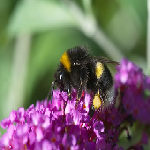

In [92]:
# image resized to 150x150 pixels and 3 color channels
img_path = 'data/train/bee/42057180260_98f4ae9345_n.jpg'
img_actual = load_img(img_path)
img_resize = load_img(img_path, target_size = (150, 150))
img_resize

In [93]:
# Input size for the CNN
actual_size = np.array(img_actual).shape
input_size = np.array(img_resize).shape

print('actual size:', actual_size)
print('after resize for input of the CNN:', input_size)



actual size: (213, 320, 3)
after resize for input of the CNN: (150, 150, 3)


In [94]:
# reescale the image pixels to the range [0, 1]
train_data_gen = ImageDataGenerator(rescale=1./255)
test_data_gen = ImageDataGenerator(rescale=1./255)

train_path = 'data/train'
test_path = 'data/test'

# Set up the train and test generators
train_batch_gen = train_data_gen.flow_from_directory( train_path,
                                          target_size = (150, 150),
                                          batch_size = 20,
                                          class_mode = 'binary',
                                          shuffle = True,)

test_batch_gen = test_data_gen.flow_from_directory( test_path,
                                        target_size = (150, 150),
                                        batch_size = 20,
                                        class_mode = 'binary',
                                        shuffle = True,)

print('Classes for binary classification:', train_batch_gen.class_indices)

Found 3677 images belonging to 2 classes.
Found 918 images belonging to 2 classes.
Classes for binary classification: {'bee': 0, 'wasp': 1}


### **Question 3**

What is the median of training accuracy for all the epochs for this model?

* 0.20
* 0.40
* 0.60
* **0.80**

In [95]:
# Compile the model with binary crossentropy loss and the Adam optimizer
optimizer = SGD(learning_rate=0.002, momentum=0.8)
cnn_model.compile(loss='binary_crossentropy', optimizer= optimizer, metrics=['accuracy'])

# Fit the model to the training data
history = cnn_model.fit( train_batch_gen,
                         epochs = 10,
                         validation_data = test_batch_gen)

Epoch 1/10


184/184 [==============================] - 10s 51ms/step - loss: 0.6665 - accuracy: 0.5915 - val_loss: 0.6100 - val_accuracy: 0.6656
Epoch 2/10
184/184 [==============================] - 9s 51ms/step - loss: 0.6008 - accuracy: 0.6717 - val_loss: 0.5858 - val_accuracy: 0.6645
Epoch 3/10
184/184 [==============================] - 9s 51ms/step - loss: 0.5495 - accuracy: 0.7302 - val_loss: 0.5514 - val_accuracy: 0.7375
Epoch 4/10
184/184 [==============================] - 9s 50ms/step - loss: 0.5158 - accuracy: 0.7536 - val_loss: 0.5266 - val_accuracy: 0.7473
Epoch 5/10
184/184 [==============================] - 9s 50ms/step - loss: 0.4877 - accuracy: 0.7718 - val_loss: 0.5578 - val_accuracy: 0.7092
Epoch 6/10
184/184 [==============================] - 9s 51ms/step - loss: 0.4530 - accuracy: 0.7963 - val_loss: 0.5156 - val_accuracy: 0.7571
Epoch 7/10
184/184 [==============================] - 9s 50ms/step - loss: 0.4434 - accuracy: 0.8012 - val_loss: 0.5045 - val_accuracy: 0.7691
Epoch 8/1

In [105]:
accuracy = history.history['accuracy']
print("median accuracy on train set:", round(np.median(accuracy), 3))

median accuracy on train set: 0.784


### **Question 4**

What is the standard deviation of training loss for all the epochs for this model?

* 0.031
* 0.061
* **0.091**
* 0.131

In [106]:
loss = history.history['loss']
print("Standard Deviation of loss on train set:", round(np.std(loss), 3))

Standard Deviation of loss on train set: 0.098


### **Data Augmentation**

For the next two questions, we'll generate more data using data augmentations. 

Add the following augmentations to the training data generator:

* `rotation_range=50,`
* `width_shift_range=0.1,`
* `height_shift_range=0.1,`
* `zoom_range=0.1,`
* `horizontal_flip=True,`
* `fill_mode='nearest'`

In [98]:
# Data augmentation is a technique used to artificially expand the size of a training dataset
# The test set is unchanged because they are used as a reference to evaluate the model
train_data_aug = ImageDataGenerator(
    rotation_range=50,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    rescale=1./255)

train_batch_aug = train_data_aug.flow_from_directory(
    train_path,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary',
    shuffle=True)

Found 3677 images belonging to 2 classes.


### **Question 5** 

Let's train our model for 10 more epochs using the same code as previously.
> **Note:** make sure you don't re-create the model - we want to continue training the model
we already started training.

What is the mean of test loss for all the epochs for the model trained with augmentations?

* 0.18
* **0.48**
* 0.78
* 0.108

In [99]:
augmented_history = cnn_model.fit( train_batch_aug,
                                   epochs = 10,
                                   validation_data = test_batch_gen )

Epoch 1/10


184/184 [==============================] - 25s 136ms/step - loss: 0.4973 - accuracy: 0.7645 - val_loss: 0.5101 - val_accuracy: 0.7636
Epoch 2/10
184/184 [==============================] - 25s 135ms/step - loss: 0.4832 - accuracy: 0.7745 - val_loss: 0.5005 - val_accuracy: 0.7691
Epoch 3/10
184/184 [==============================] - 25s 137ms/step - loss: 0.4833 - accuracy: 0.7794 - val_loss: 0.4637 - val_accuracy: 0.7854
Epoch 4/10
184/184 [==============================] - 25s 137ms/step - loss: 0.4749 - accuracy: 0.7808 - val_loss: 0.5277 - val_accuracy: 0.7331
Epoch 5/10
184/184 [==============================] - 25s 137ms/step - loss: 0.4776 - accuracy: 0.7846 - val_loss: 0.4753 - val_accuracy: 0.7789
Epoch 6/10
184/184 [==============================] - 25s 136ms/step - loss: 0.4676 - accuracy: 0.7871 - val_loss: 0.4652 - val_accuracy: 0.7789
Epoch 7/10
184/184 [==============================] - 25s 138ms/step - loss: 0.4646 - accuracy: 0.7930 - val_loss: 0.4502 - val_accuracy: 0.7

In [107]:
val_loss = history.history['val_loss']
print("Mean loss of test set:", round(np.mean(val_loss), 3))

Mean loss of test set: 0.538


### **Question 6**

What's the average of test accuracy for the last 5 epochs (from 6 to 10)
for the model trained with augmentations?

* 0.38
* 0.58
* **0.78**
* 0.98

In [102]:
last_five_accuracy = history.history['val_accuracy'][-5:]
print("Average Accuracy for last 5 epochs on test set:", round(np.average(last_five_accuracy), 3))

Average Accuracy for last 5 Epochs on test set: 0.764
